# Clustering

In [28]:
# devtools::install_github("sdaza/sampler")
library(sampler)
library(data.table)
library(simstudy)
library(survey)
library(performance)


# Simulate school data

We are going to use the `simstudy` package.

- 300 schools 
- Different number of classes
- Different number of students


In [29]:
set.seed(12212022)
school = defData(
  varname = "school_effect", dist = "normal",
  formula = 2, variance = 0.5, id = "id_school"
)

school = defData(school,
  varname = "n_classes",
  dist = "noZeroPoisson", formula = 7
)

# generate date for 300 schools
dt_school = genData(300, school)

# class level data
class = defDataAdd(varname = "class_effect", dist = "normal", formula = 3, variance = 0.7)
class = defDataAdd(class, varname = "n_students", dist = "noZeroPoisson", 
  formula = 20)

dt_class = genCluster(dt_school,
  cLevelVar = "id_school",
  numIndsVar = "n_classes", level1ID = "id_class")

dt_class = addColumns(class, dt_class)

# student level data
student = defDataAdd(varname = "test", dist = "normal",
    formula = "50 + school_effect + class_effect", variance = 2)

student = defDataAdd(student, varname = "drug", dist = "binary",
    formula = "-6.5 + school_effect + class_effect", link="logit")

dt_student = genCluster(dt_class, cLevelVar = "id_class", numIndsVar = "n_students",
    level1ID = "id_student")

dt_student = addColumns(student, dt_student)
dt_student[, n_schools := length(unique((id_school)))]
dt = list('school'=dt_school, 'class'=dt_class, 'student'=dt_student)

In [30]:
nrow(dt_student)

[1] 42647

In [31]:
head(dt_student)

id_school,school_effect,n_classes,id_class,class_effect,n_students,id_student,test,drug,n_schools
<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>
1,2.25399,11,1,2.289866,11,1,52.56004,0,300
1,2.25399,11,1,2.289866,11,2,53.58434,0,300
1,2.25399,11,1,2.289866,11,3,53.29494,1,300
1,2.25399,11,1,2.289866,11,4,56.48284,0,300
1,2.25399,11,1,2.289866,11,5,53.71133,0,300
1,2.25399,11,1,2.289866,11,6,54.95111,0,300


In [32]:
prop.table(table(dt_student$drug))


        0         1 
0.7584121 0.2415879 

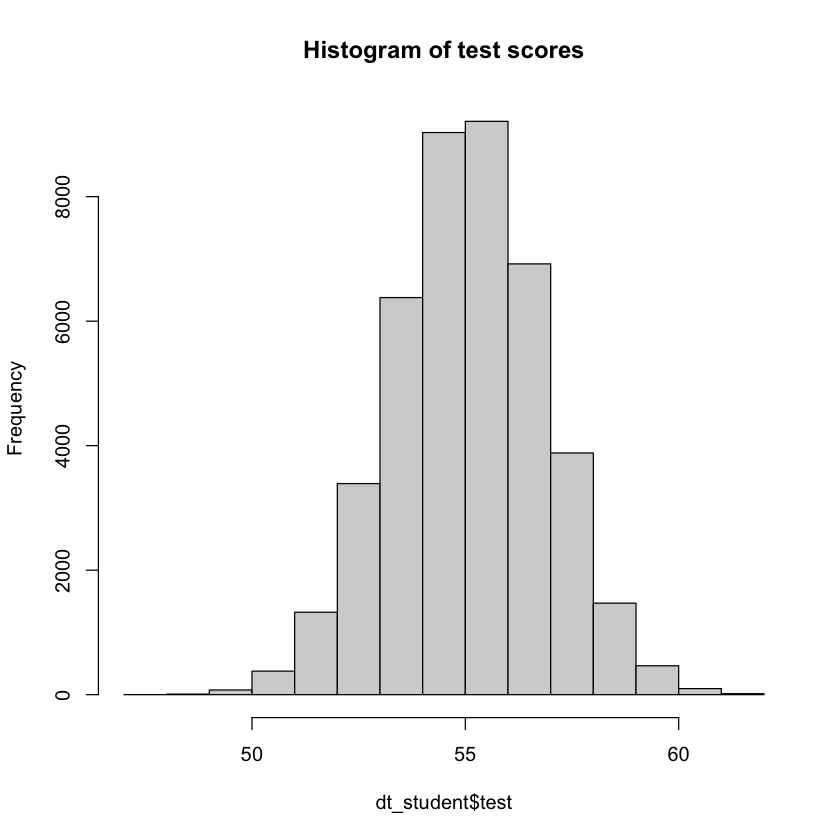

In [33]:
hist(dt_student$test, main="Histogram of test scores")

# Intra-class correlation

In [34]:
library(lme4)
library(performance)

m0 = lmer(test ~ 1 + (1|id_school), data=dt_student)
test_icc = performance::icc(m0, by_group=FALSE)$ICC_unadjusted
print(paste0('Test score ICC: ', round(test_icc, 3)))

[1] "Test score ICC: 0.175"


In [35]:
m1 = glmer(drug ~ 1 + (1|id_school),family='binomial', data=dt_student)
drug_icc = performance::icc(m1, by_group=FALSE)$ICC_unadjusted
print(paste0('Drug use ICC: ', round(drug_icc, 3)))

[1] "Drug use ICC: 0.129"


# Define sample

In [36]:
# number of students
nrow(dt_student)

[1] 42647

In [37]:
set.seed(12212022)
sample_schools = 50
sample_students = 10
cl = dt_school[sample(nrow(dt_school), size=sample_schools),][, .(id_school)]

print(paste0('Any duplicated schools?: ', anyDuplicated(cl$id_school)))
cl[, f1 := sample_schools/nrow(dt_school)]
dt_student[, total_school_students := .N, by=id_school]
dt_student[, total_students := .N]

cl = merge(cl, dt_student, by='id_school')
cl = cl[,.SD[sample(.N, min(sample_students, .N))], by = id_school]
print(paste0('Any duplicated student?: ', anyDuplicated(cl$id_student)))

cl[, f2 := .N/total_school_students, by=id_school]
cl[, w1 := 1/f1]
cl[, w2 := 1/f2]
cl[, w := w1*w2]
tail(cl)

[1] "Any duplicated schools?: 0"
[1] "Any duplicated student?: 0"


id_school,f1,school_effect,n_classes,id_class,class_effect,n_students,id_student,test,drug,n_schools,total_school_students,total_students,f2,w1,w2,w
<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
300,0.1666667,2.282758,6,2116,3.356944,19,42568,53.62304,0,300,133,42647,0.07518797,6,13.3,79.8
300,0.1666667,2.282758,6,2117,3.452889,20,42594,56.28139,1,300,133,42647,0.07518797,6,13.3,79.8
300,0.1666667,2.282758,6,2115,2.856317,28,42563,54.17133,1,300,133,42647,0.07518797,6,13.3,79.8
300,0.1666667,2.282758,6,2117,3.452889,20,42585,55.75463,0,300,133,42647,0.07518797,6,13.3,79.8
300,0.1666667,2.282758,6,2114,1.332155,21,42518,52.88977,0,300,133,42647,0.07518797,6,13.3,79.8
300,0.1666667,2.282758,6,2119,3.474041,20,42643,54.29066,0,300,133,42647,0.07518797,6,13.3,79.8


In [38]:
summary(cl$w)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  28.20   64.20   89.10   90.56  114.00  189.60 

In [39]:
# sum of weigths
round(sum(cl$w)) 

# vs population size
nrow(dt_student)


[1] 45282

[1] 42647

# Define design using the `survey` package

In [40]:
d_cl_0 = svydesign(id = ~ 0, data = cl, fpc = ~ total_students)
d_cl_1 = svydesign(id = ~ id_school, data = cl, probs = ~f1+f2, fpc = ~n_schools)

In [41]:
mean(cl$drug)
weighted.mean(cl$drug, cl$w)

[1] 0.26

[1] 0.2392341

In [42]:
svymean(~drug, design = d_cl_0, deff=TRUE)

         mean       SE DEff
drug 0.260000 0.019521    1

In [43]:
drug_estimate_0 = svymean(~drug, design = d_cl_0, deff=TRUE)
drug_ci_0 = confint(drug_estimate_0)
drug_moe_0 = as.vector(drug_ci_0 - drug_estimate_0[[1]])[2]

print(paste0('Drug use estimate: ', round(drug_estimate_0[1], 3)))
print(paste0('Drug use MOE ', round(drug_moe_0, 3)))

[1] "Drug use estimate: 0.26"
[1] "Drug use MOE 0.038"


In [44]:
svymean(~drug, design = d_cl_1, deff=TRUE)

         mean       SE   DEff
drug 0.239234 0.021725 1.3085

In [45]:
drug_estimate_1 = svymean(~drug, design = d_cl_1, deff=TRUE)
drug_ci_1 = confint(drug_estimate_1)
drug_moe_1 = as.vector(drug_ci_1 - drug_estimate_1[[1]])[2]

print(paste0('Drug use estimate: ', round(drug_estimate_1[1], 3)))
print(paste0('Drug use MOE ', round(drug_moe_1, 3)))

[1] "Drug use estimate: 0.239"
[1] "Drug use MOE 0.043"


# Less schools, more students per school

In [46]:
set.seed(12212022)
sample_schools = 25
sample_students = 20
cl = dt_school[sample(nrow(dt_school), size=sample_schools),][, .(id_school)]

print(paste0('Any duplicated schools?: ', anyDuplicated(cl$id_school)))
cl[, f1 := sample_schools/nrow(dt_school)]
dt_student[, total_school_students := .N, by=id_school]
dt_student[, total_students := .N]

cl = merge(cl, dt_student, by='id_school')
cl = cl[,.SD[sample(.N, min(sample_students, .N))], by = id_school]
print(paste0('Any duplicated student?: ', anyDuplicated(cl$id_student)))

cl[, f2 := .N/total_school_students, by=id_school]
cl[, w1 := 1/f1]
cl[, w2 := 1/f2]
cl[, w := w1*w2]
tail(cl)

[1] "Any duplicated schools?: 0"
[1] "Any duplicated student?: 0"


id_school,f1,school_effect,n_classes,id_class,class_effect,n_students,id_student,test,drug,n_schools,total_school_students,total_students,f2,w1,w2,w
<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
290,0.08333333,3.531387,9,2050,1.983310,23,41217,58.13589,1,300,180,42647,0.1111111,12,9,108
290,0.08333333,3.531387,9,2045,3.112747,14,41110,56.15245,1,300,180,42647,0.1111111,12,9,108
290,0.08333333,3.531387,9,2045,3.112747,14,41108,54.98271,1,300,180,42647,0.1111111,12,9,108
290,0.08333333,3.531387,9,2049,2.132653,28,41181,54.11293,0,300,180,42647,0.1111111,12,9,108
290,0.08333333,3.531387,9,2053,2.577219,13,41277,56.37036,0,300,180,42647,0.1111111,12,9,108
290,0.08333333,3.531387,9,2052,1.802238,18,41256,54.28220,0,300,180,42647,0.1111111,12,9,108


In [47]:
mean(cl$drug)
weighted.mean(cl$drug, cl$w)

[1] 0.29

[1] 0.2751706

In [48]:
d_cl_2 = svydesign(id = ~ id_school, data = cl, probs = ~ f1+f2, fpc = ~n_schools)

In [49]:
svymean(~drug, design = d_cl_2, deff=TRUE)

         mean       SE   DEff
drug 0.275171 0.032892 2.7378

In [50]:
drug_estimate_2 = svymean(~drug, design = d_cl_2, deff=TRUE)
drug_ci_2 = confint(drug_estimate_2)
drug_moe_2 = as.vector(drug_ci_2 - drug_estimate_2[[1]])[2]

print(paste0('Drug use estimate: ', round(drug_estimate_2[1], 3)))
print(paste0('Drug use MOE ', round(drug_moe_2, 3)))

[1] "Drug use estimate: 0.275"
[1] "Drug use MOE 0.064"


# PPS example

In [51]:
# example from groves' book
block = 1:9
size = c(20, 100, 50, 15, 18, 45, 20, 35, 12)
blocks = data.table(block, size)
blocks[, end := cumsum(size)]

svalues = c(39, 144, 249)
blocks[, start := shift(end, fill=1)]
selected = sapply(svalues, function(x) {
   blocks[block == which(start <= x & end >= x), block]
})

# selected blocks
sblocks = blocks[selected]

In [52]:
sblocks[, ip := (size * 3) / 315]
sblocks[, hip := 7/size]
sblocks[, w := 1/(ip*hip)]
sblocks[, p := size/315*3]

In [53]:
sblocks

block,size,end,start,ip,hip,w,p
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,100,120,20,0.9523810,0.07,15,0.9523810
3,50,170,120,0.4761905,0.14,15,0.4761905
7,20,268,248,0.1904762,0.35,15,0.1904762


In [54]:
blocks[, p := size / sum(size)]
blocks[sample(.N, 3, prob=p)]
blocks[, sp := 3 * p]

block,size,end,start,p
<int>,<dbl>,<dbl>,<dbl>,<dbl>
3,50,170,120,0.15873016
6,45,248,203,0.14285714
4,15,185,170,0.04761905
